In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [117]:
# w_c_q = w_c/w_q: cavity frequency w.r.t. qubit frequency
# lambda_q = lambda/w_q: lambda w.r.t. qubit frequency

w_c_q = np.linspace(0.8, 2.2, 5000)
N = 3
mu = 1e8
evals_mat = np.zeros((len(w_c_q),2*2*N))

lambda_q = 0.1
theta = np.pi/6
idx = 0

sz1 = tensor(sigmaz(), qeye(2), qeye(N))
sx1 = tensor(sigmax(), qeye(2), qeye(N))

sz2 = tensor(qeye(2), sigmaz(), qeye(N))
sx2 = tensor(qeye(2), sigmax(), qeye(N))

adag = tensor(qeye(2), qeye(2), create(N))
a = tensor(qeye(2), qeye(2), destroy(N))

for wc in w_c_q:
    H = -0.5 * (sz1 + sz2) + wc * adag * a + lambda_q * (adag + a) * (np.cos(theta) * (sx1 + sx2) - np.sin(theta) * (sz1 + sz2)) + 0.04 * adag * adag * a * a
    evals, ekets = H.eigenstates()
    evals_mat[idx,:] = np.real(evals)
    idx += 1

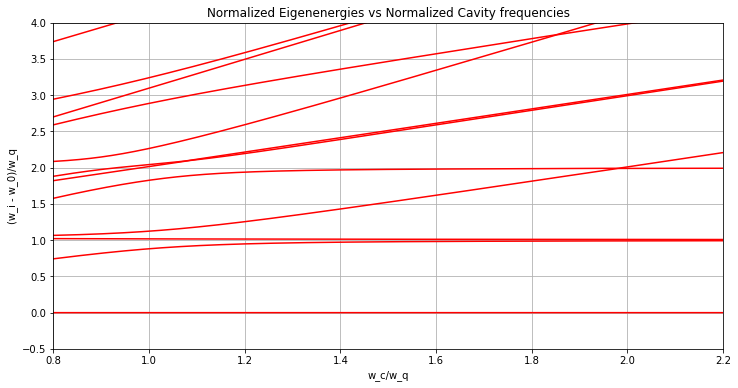

In [118]:
fig, ax = plt.subplots(figsize=(12,6))

for n in range(12):
    
    # A plot of normalized eigenenergy differences vs the normalized cavity frequencies
    
    ax.plot(w_c_q, (evals_mat[:,n]-evals_mat[:,0]), 'r')
    
ax.set_xlim(0.8,2.2)
ax.set_ylim(-0.5,4)
ax.set_xlabel('w_c/w_q')
ax.set_ylabel('(w_i - w_0)/w_q')
ax.set_title('Normalized Eigenenergies vs Normalized Cavity frequencies')
ax.grid()

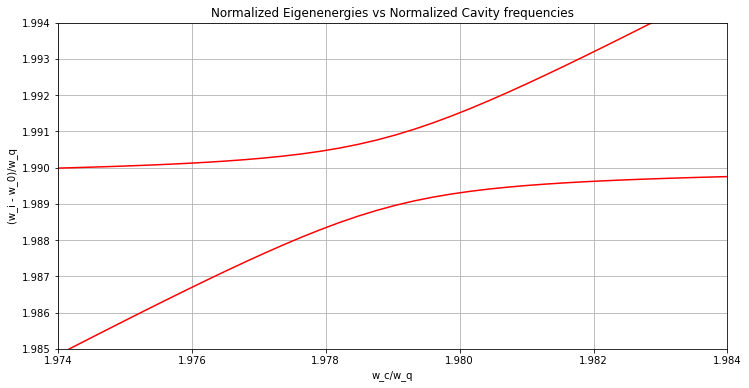

In [119]:
fig, ax = plt.subplots(figsize=(12,6))

for n in range(12):
    
    # A plot of normalized eigenenergy differences vs the normalized cavity frequencies
    
    ax.plot(w_c_q, (evals_mat[:,n]-evals_mat[:,0]), 'r')
    
ax.set_xlim(1.974, 1.984)
ax.set_ylim(1.985, 1.994)
ax.set_xlabel('w_c/w_q')
ax.set_ylabel('(w_i - w_0)/w_q')
ax.set_title('Normalized Eigenenergies vs Normalized Cavity frequencies')
ax.grid()

In [120]:
np.argmin(evals_mat[:,4] - evals_mat[:,3])

4210

In [121]:
w_c_q[4210]

1.9790358071614325

In [122]:
wq = 6 * 10**9
w0 = evals_mat[4210,0]
w3 = evals_mat[4210,3]
w4 = evals_mat[4210,4]
w_43 = (w4 - w3) * wq
w_d = (w3 + w4 - (2 * w0)) * wq / 2
tau = (1 / (4 * w_43))

In [123]:
def coefficient(t,args):
    return 5.3 * (np.exp(-(t*t)/(2*tau*tau))/(tau*np.sqrt(2*np.pi))) * np.cos(w_d * t)

In [124]:
w_d

11939574543.430899

In [125]:
H_min = wq * (-0.5 * (sz1 + sz2) + w_c_q[4210] * adag * a + lambda_q * (adag + a) * (np.cos(theta) * (sx1 + sx2) - np.sin(theta) * (sz1 + sz2))) +  mu * (adag * adag * a * a)
eval_min, eket_min = H_min.eigenstates()
X_dest = 0
C1_dest = 0
C2_dest = 0

sm1 = tensor(destroy(2), qeye(2), qeye(N))
sp1 = tensor(create(2), qeye(2), qeye(N))

sm2 = tensor(qeye(2), destroy(2), qeye(N))
sp2 = tensor(qeye(2), create(2), qeye(N))

for j in range(12):
    for k in range(3, 5):
        if k > j:
            X_jk =  eket_min[j].dag() * (a + adag) * eket_min[k]
            X_dest += X_jk * eket_min[j] * eket_min[k].dag()
                        
for j in range(len(ekets)):
    for k in range(len(ekets)):
        if k > j:
            C1_jk = eket_min[j].dag() * (sm1 + sp1) * eket_min[k]
            C2_jk = eket_min[j].dag() * (sm2 + sp2) * eket_min[k]
            C1_dest += C1_jk * eket_min[j] * eket_min[k].dag()
            C2_dest += C2_jk * eket_min[j] * eket_min[k].dag()

t = np.linspace(0, 3 * np.pi/(6 * 10**6), 5000)
H = [H_min, [(a + adag), coefficient]]

psi0 = tensor(basis(2,0), basis(2,0), fock(N,0))
options = Options(nsteps = 100000)
X = mesolve(H, psi0, t, [], e_ops = [X_dest.dag() * X_dest], options = options)
C1 = mesolve(H, psi0, t, [], e_ops = [C1_dest.dag() * C1_dest], options = options)
C2 = mesolve(H, psi0, t, [], e_ops = [C2_dest.dag() * C2_dest], options = options)
G = mesolve(H, psi0, t, [], e_ops = [C1_dest.dag() * C2_dest.dag() * C2_dest * C1_dest], options = options)

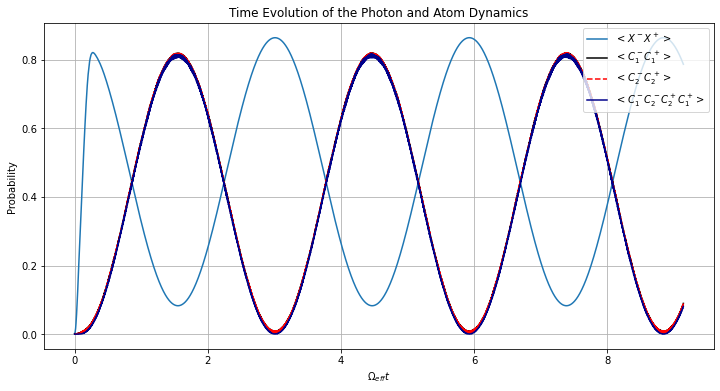

In [114]:
# mu = 0.04

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

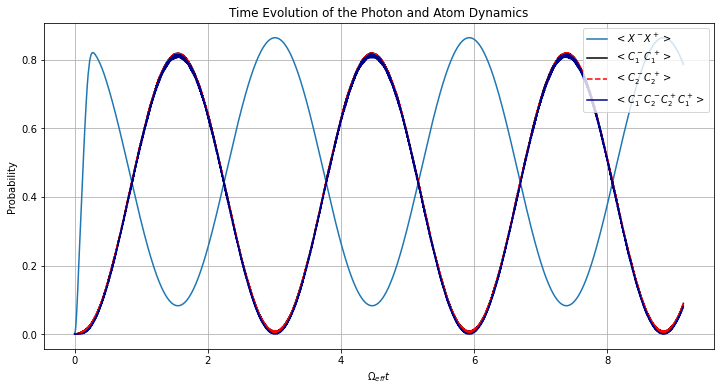

In [23]:
# mu = 10

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [24]:
np.max(X.expect[0])

0.8638023014737014

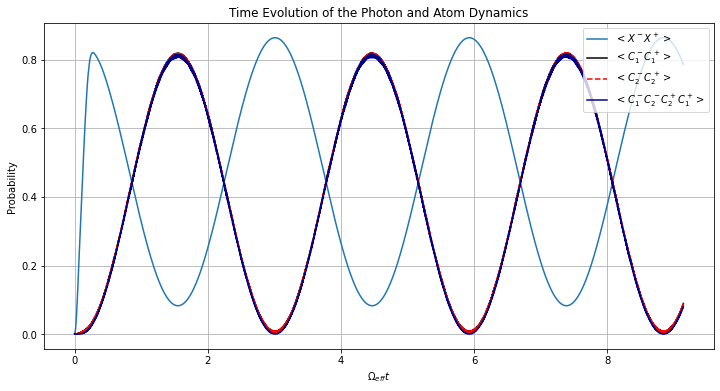

In [34]:
# mu = 100

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [35]:
np.max(X.expect[0])

0.8638025416629147

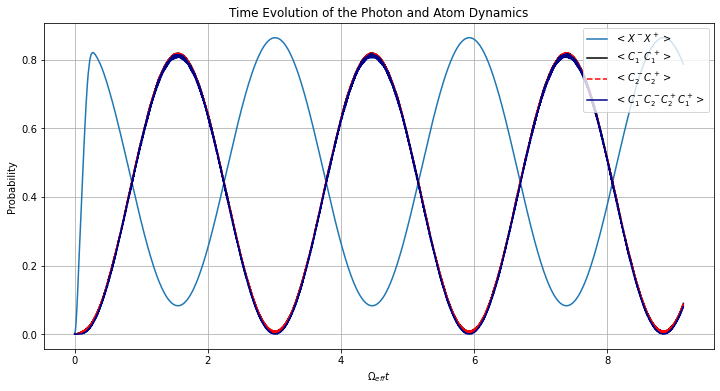

In [45]:
# mu = 1e4

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [46]:
np.max(X.expect[0])

0.8638184527074547

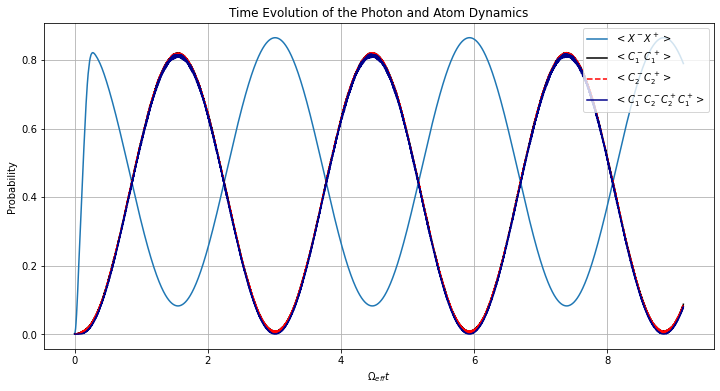

In [56]:
# mu = 1e6

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [57]:
np.max(X.expect[0])

0.8652963182099004

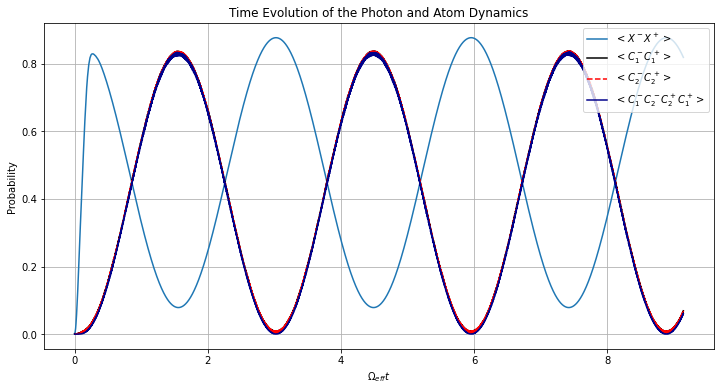

In [67]:
# mu = 1e7

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [68]:
np.max(X.expect[0])

0.8763977349983184

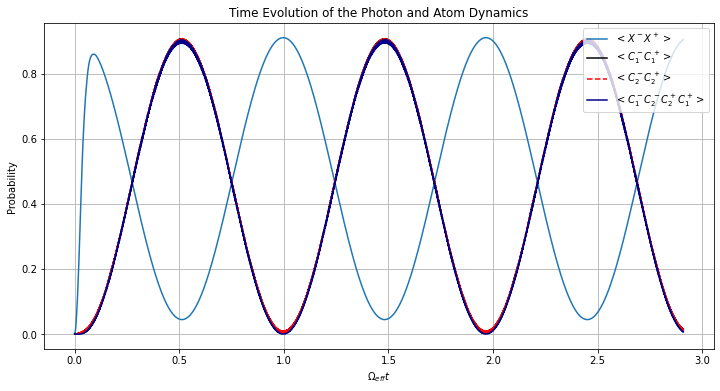

In [126]:
# mu = 1e8

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t / np.pi, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t / np.pi, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t / np.pi, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t / np.pi, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [127]:
np.max(X.expect[0])

0.9104715619547238

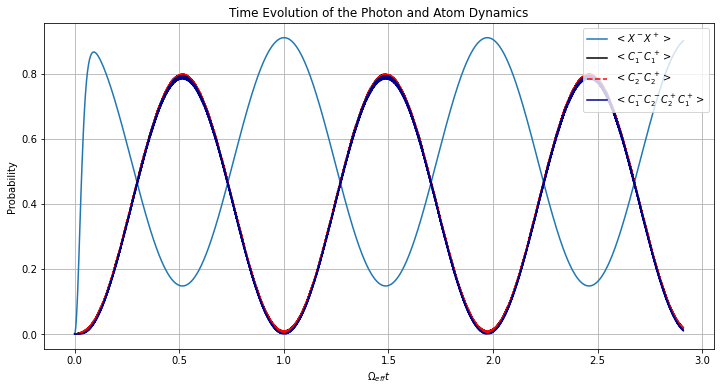

In [90]:
# mu = 5e8

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t / np.pi, X.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t / np.pi, C1.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t / np.pi, C2.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t / np.pi, G.expect[0], 'darkblue', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics')
ax.grid()

In [91]:
np.max(X.expect[0])

0.911197994164938

In [128]:
# k is the same as kappa
# g is the same as gamma

k = 4 * 10**(-5) * wq
g = 4 * 10**(-5) * wq

X1 = mesolve(H, psi0, t, c_ops = [np.sqrt(k) * X_dest, np.sqrt(g) * (C1_dest + C2_dest)], e_ops = [X_dest.dag() * X_dest], options = options)
C11 = mesolve(H, psi0, t, c_ops = [np.sqrt(k) * X_dest, np.sqrt(g) * (C1_dest + C2_dest)], e_ops = [C1_dest.dag() * C1_dest], options = options)
C21 = mesolve(H, psi0, t, c_ops = [np.sqrt(k) * X_dest, np.sqrt(g) * (C1_dest + C2_dest)], e_ops = [C2_dest.dag() * C2_dest], options = options)
G1 = mesolve(H, psi0, t, c_ops = [np.sqrt(k) * X_dest, np.sqrt(g) * (C1_dest + C2_dest)], e_ops = [C1_dest.dag() * C2_dest.dag() * C2_dest * C1_dest], options = options)

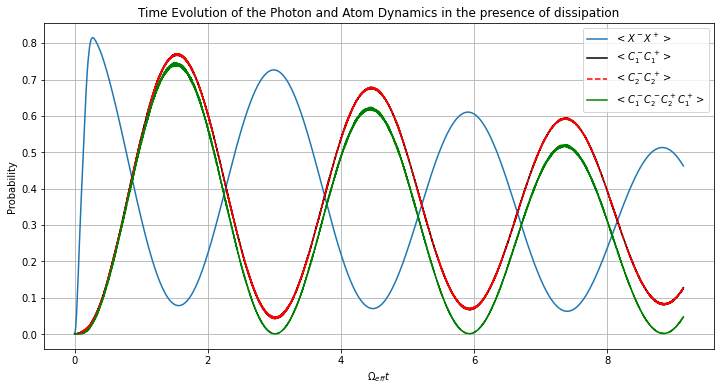

In [116]:
# mu = 0.04

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X1.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C11.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C21.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G1.expect[0], 'g', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics in the presence of dissipation')
ax.grid()

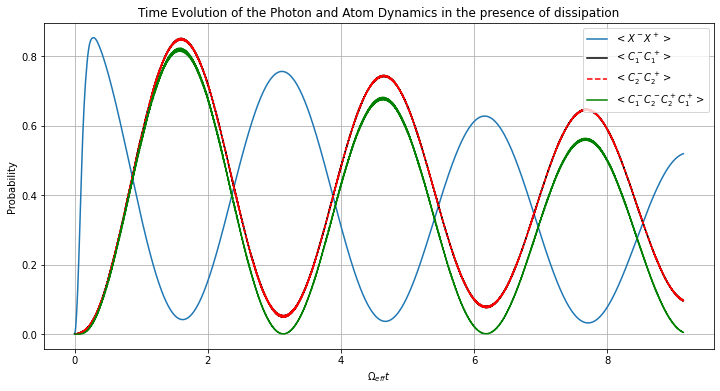

In [129]:
# mu = 1e8

fig, ax = plt.subplots(figsize=(12,6))
Omega = w_43/2

ax.plot(Omega * t, X1.expect[0], label = '$<X^-X^+>$')
ax.plot(Omega * t, C11.expect[0], 'black', label = '$<C_1^-C_1^+>$')
ax.plot(Omega * t, C21.expect[0], 'r--', label = '$<C_2^-C_2^+>$')
ax.plot(Omega * t, G1.expect[0], 'g', label = '$<C_1^-C_2^-C_2^+C_1^+>$')
ax.legend(loc = 'upper right')
ax.set_xlabel('$\Omega_{eff}t$')
ax.set_ylabel('Probability')
ax.set_title('Time Evolution of the Photon and Atom Dynamics in the presence of dissipation')
ax.grid()